<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DPT/DPT_inference_notebook_(semantic_segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 67 kB 2.2 MB/s 
     |████████████████████████████████| 895 kB 9.2 MB/s 
     |████████████████████████████████| 6.5 MB 45.8 MB/s 
     |████████████████████████████████| 596 kB 65.6 MB/s 


## Define model

In [3]:
from transformers import DPTForSemanticSegmentation

model = DPTForSemanticSegmentation.from_pretrained("Intel/dpt-large-ade")

Downloading:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28G [00:00<?, ?B/s]

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-large-ade and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_var', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_var']
You should probably TRAIN this mo

## Prepare image

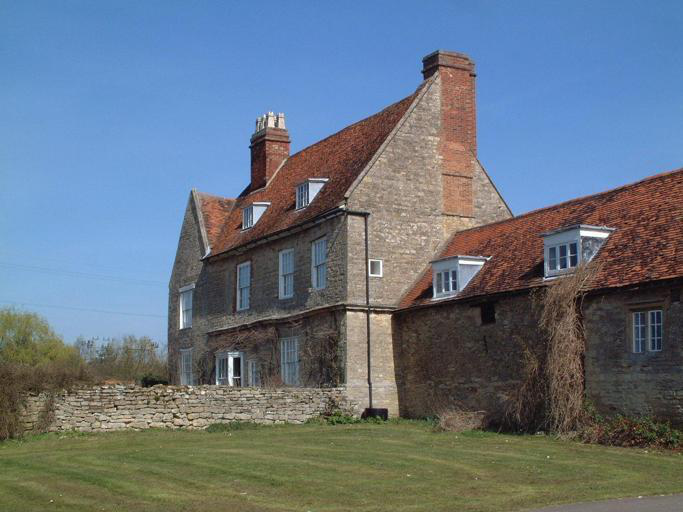

In [4]:
from PIL import Image
import requests

url = 'https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/raw/main/ADE_val_00000001.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [5]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

net_h = net_w = 480

transform = Compose([
        Resize((net_h, net_w)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

In [6]:
pixel_values = transform(image).unsqueeze(0)

## Forward pass

In [7]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


## Visualize

In [8]:
logits.shape

torch.Size([1, 150, 480, 480])

In [9]:
# interpolate logits to original size
prediction = torch.nn.functional.interpolate(
                logits, 
                size=image.size[::-1], 
                mode="bicubic", 
                align_corners=False
            )
prediction = torch.argmax(prediction, dim=1) + 1
prediction = prediction.squeeze().cpu().numpy()
prediction

array([[ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       ...,
       [10, 10, 10, ...,  7,  7,  7],
       [10, 10, 10, ...,  7,  7,  7],
       [10, 10, 10, ...,  7,  7,  7]])

In [10]:
adepallete = [0,0,0,120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255]

In [11]:
# put colormap
predicted_seg = Image.fromarray(prediction.squeeze().astype('uint8'))
predicted_seg.putpalette(adepallete)

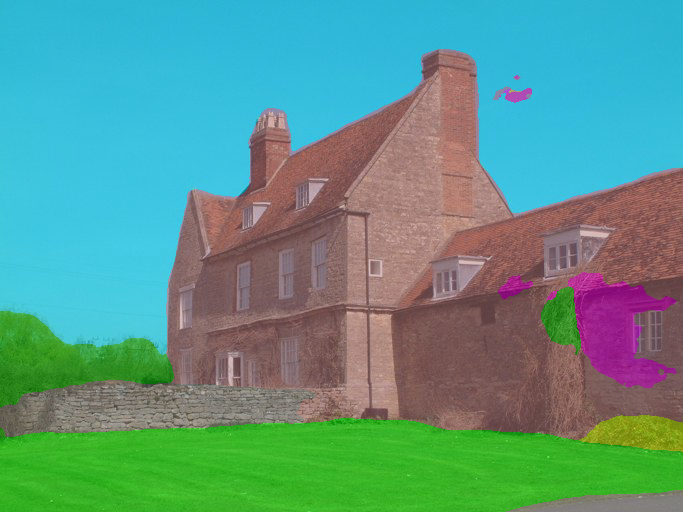

In [12]:
import numpy as np

# blend with original image
out = Image.blend(image, predicted_seg.convert("RGB"), alpha=0.5)
out